In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import dump
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random

In [2]:
dataset_dir = 'Aerial_Landscapes'
categories = ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland',
              'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']

lbp_radius = 1
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
resize_size = (128, 128)

In [3]:
# dataset imbalance
category_limits = {cat: 800 - i * 50 for i, cat in enumerate(categories)}

In [4]:
def extract_lbp_features(img_gray):
    lbp = local_binary_pattern(img_gray, lbp_n_points, lbp_radius, lbp_method)
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, lbp_n_points + 3),
                           range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

In [5]:
features = []
labels = []

for category in tqdm(categories):
    folder_path = os.path.join(dataset_dir, category)
    img_list = os.listdir(folder_path)
    random.shuffle(img_list)
    selected_imgs = img_list[:category_limits[category]]

    for img_name in selected_imgs:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, resize_size)
        lbp_feature = extract_lbp_features(img)
        features.append(lbp_feature)
        labels.append(category)

X = np.array(features)
le = LabelEncoder()
y = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
clf.fit(X_train, y_train)

dump(clf, 'lbp_svm_model_imbalanced.joblib')
dump(le, 'label_encoder_imbalanced.joblib')
print("Model saved as lbp_svm_model_imbalanced.joblib")

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.84s/it]


Model saved as lbp_svm_model_imbalanced.joblib
Accuracy: 0.5770
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.59      0.69      0.64       177
     Airport       0.44      0.60      0.51       153
       Beach       0.51      0.55      0.53       129
        City       0.55      0.70      0.62       137
      Desert       0.62      0.41      0.50       123
      Forest       0.80      0.86      0.83       114
   Grassland       0.71      0.78      0.74        86
     Highway       0.55      0.40      0.46        93
        Lake       0.60      0.48      0.53        77
    Mountain       0.53      0.60      0.56        77
     Parking       0.62      0.51      0.56        51
        Port       0.59      0.44      0.51        45
     Railway       0.45      0.24      0.32        37
 Residential       0.75      0.18      0.29        33
       River       0.00      0.00      0.00        18

    accuracy                           0.58    

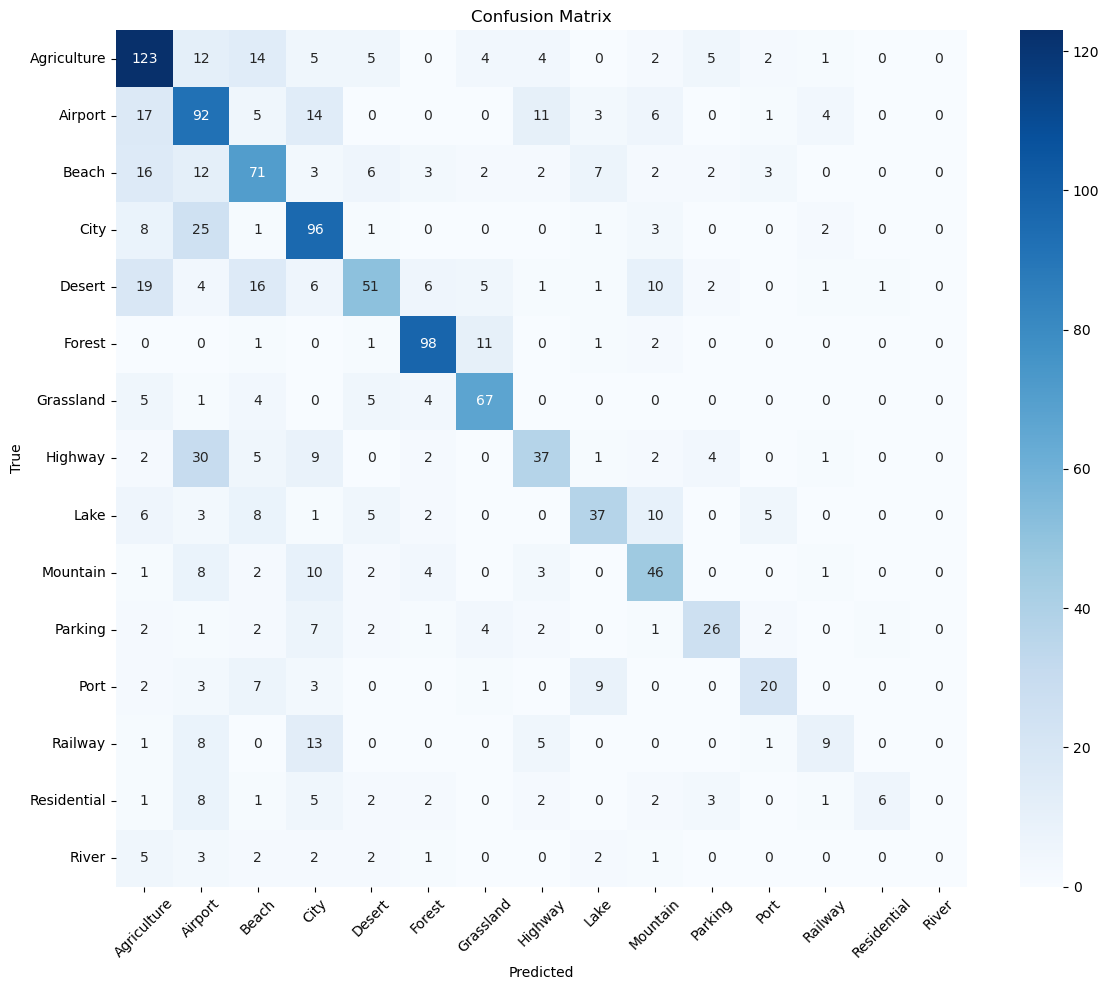

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix_imbalanced.png")
plt.show()

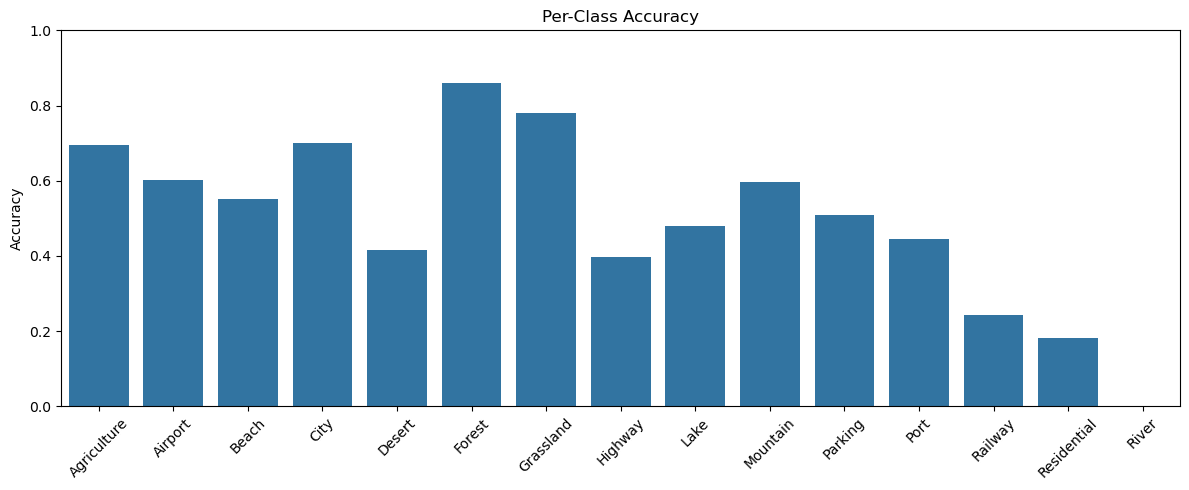

In [7]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
sns.barplot(x=le.classes_, y=class_accuracy)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("per_class_accuracy_imbalanced.png")
plt.show()